In [95]:
import os
import datetime
import doralite
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import doralite
import glob
import subprocess
import momlevel
import itertools

from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

config = {
    "startyr": "1",
    "endyr": "100",
    "dora_id": "cm5-3",
    "pathPP": "",
}

for k, v in config.items():
    config[k] = (
        os.environ[f"MAR_{k.upper()}"]
        if f"MAR_{k.upper()}" in os.environ.keys()
        else v
    )

numpy version  :  1.23.5
pandas version :  1.5.3
xarray version :  2023.3.0


In [96]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

# 1. List of all experiments to consider
experiments = [doralite.dora_metadata(x) for x in config["dora_id"].split(",")]

# Define start and end years
start = int(config["startyr"])
end = int(config["endyr"])

print(start,end)

1 100


In [97]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

In [98]:
datafiles = []
staticfiles = []

for experiment in experiments:
    _pathPP = experiment["pathPP"]
    
    component = "ocean_annual_z"
    static = f"{component}/{component}.static.nc"
    varname = "so"
    
    chunk = "5yr"
    filelist = sorted(glob.glob(f"{_pathPP}{component}/ts/annual/{chunk}/{component}.*.{varname}.nc"))
    
    filelist = [x for x in filelist if is_in_range(x,start,end)]
    _staticfile = f"{_pathPP}/{static}"
    
    staticfiles.append(_staticfile)
    datafiles.append(filelist)

In [99]:
allfiles = sorted(list(itertools.chain(*datafiles)) + staticfiles)
_ = [print(x) for x in allfiles]

if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+allfiles
    _ = subprocess.check_output(cmd)

/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp//ocean_annual_z/ocean_annual_z.static.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0001-0005.so.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0011-0015.so.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0016-0020.so.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0021-0025.so.nc
/archive/John.Krasting/fre/cm5/cm5_c96_am5f7c1r0_b06_piC_galb/gfdl.ncrc5-intel23-classic-prod-openmp/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.0026-0030.so.nc
/archive/John.Krasting/fre/cm5/cm5_

### Note- this is using a quick and dirty shelf estimate using 1000m bathymetry south of 60S...

In [100]:
# static = xr.open_dataset(staticfiles[0])

# idx_SO_1k = (static.geolat <= -60) & (static.deptho <= 1000)
# mask_SOshelf = xr.where(idx_SO_1k, 1, np.nan)

In [105]:
# import gsw

# ds = xr.open_mfdataset(filelist, use_cftime=True)

# p = xr.apply_ufunc(gsw.p_from_z, -1*ds['z_l'], static['geolat'], 0, 0, dask='parallelized')
# sa = xr.apply_ufunc(gsw.SA_from_SP, ds.so, p, static['geolon'], static['geolat'], dask='parallelized')  
# sa_bottom = (sa * mask_SOshelf).chunk({'time':1}).ffill('z_l').isel(z_l=-1).where(static.wet==1)

# #(sa_bottom[0,:,:]).plot()

In [113]:
# area_shelf = (static.areacello * mask_SOshelf).sum(dim=['xh','yh'])

# sa_bottom_avg = (sa_bottom * static.areacello).sum(dim=['xh','yh']) / area_shelf

# sa_bottom_avg.plot()
# plt.title(f"SO shelf-averaged bottom salinity, {config['dora_id']}", fontsize=12)
# plt.ylabel('S_A (g kg$^{-1}$)', fontsize=10)
# #plt.xlim([start, end])

### Looping through all experiments and creating the figure

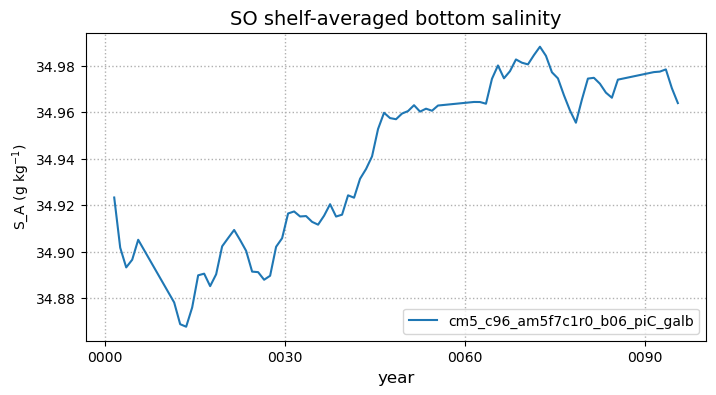

In [117]:
import gsw

fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(8,4), dpi=100)

for n,exp in enumerate(experiments):

    expName = exp["expName"]
    
    # Open datasets
    ds = xr.open_mfdataset(datafiles[n], use_cftime=True)
    static = xr.open_dataset(staticfiles[n], use_cftime=True)
    
    # Create mask for shelf -- note that this should be updated if you want something "real"
    idx_SO_1k = (static.geolat <= -60) & (static.deptho <= 1000)
    mask_SOshelf = xr.where(idx_SO_1k, 1, np.nan)
    
    area_shelf = (static.areacello * mask_SOshelf).sum(dim=['xh','yh'])
    
    # Find bottom salinity, converted to absolute salinity
    p = xr.apply_ufunc(gsw.p_from_z, -1*ds['z_l'], static['geolat'], 0, 0, dask='parallelized')
    sa = xr.apply_ufunc(gsw.SA_from_SP, ds.so, p, static['geolon'], static['geolat'], dask='parallelized')  
    sa_bottom = (sa * mask_SOshelf).chunk({'time':1}).ffill('z_l').isel(z_l=-1).where(static.wet==1)
    
    sa_bottom_avg = (sa_bottom * static.areacello).sum(dim=['xh','yh']) / area_shelf
    
    # Plotting
    sa_bottom_avg.plot(ax=axis, label=expName, linestyle='solid', linewidth=1.5)
    
axis.legend(loc='lower right',fontsize=10)
axis.set_title(f"SO shelf-averaged bottom salinity", fontsize=14)
axis.set_ylabel('S_A (g kg$^{-1}$)', fontsize=10)
axis.set_xlabel('year', fontsize=12)
axis.grid(linewidth=1, linestyle="dotted")